In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest26d'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 90
    epochs_patience = 12

    lr = 1e-4
    loss = "DiceLoss"

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



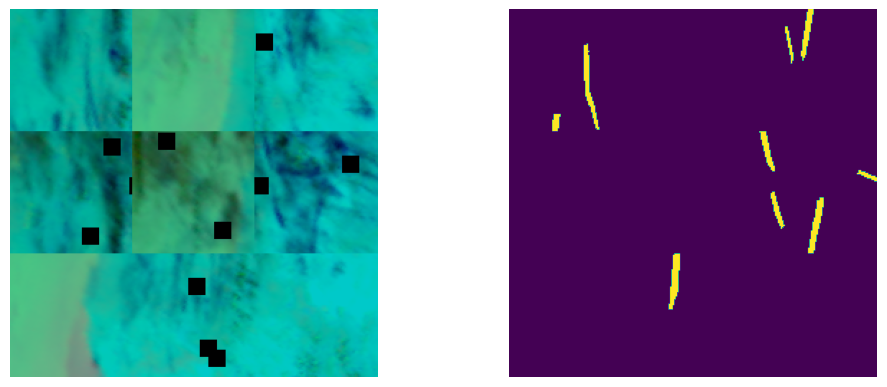

In [5]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(112, dataset_train)

# Model

In [6]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  timm-resnest26d


In [7]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [8]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(CFG.epochs):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        epoch_best=epoch
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
    
    if epoch-epoch_best>=CFG.epochs_patience:
        print('Early Stopping')
        break
        
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/90  Mem : 7.79GB  LR : 1.00E-04  Loss: 0.8049: 100%|██████████| 642/642 [01:22<00:00,  7.77it/s]
Val Loss: 0.6515: 100%|██████████| 58/58 [00:03<00:00, 18.34it/s]


FBeta : 0.5241	thresh : 0.33	SAVED MODEL



Epoch 1/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.5413: 100%|██████████| 642/642 [01:21<00:00,  7.84it/s]
Val Loss: 0.5456: 100%|██████████| 58/58 [00:03<00:00, 17.03it/s]


FBeta : 0.5014	thresh : 0.09



Epoch 2/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4971: 100%|██████████| 642/642 [01:22<00:00,  7.82it/s]
Val Loss: 0.4972: 100%|██████████| 58/58 [00:03<00:00, 16.70it/s]


FBeta : 0.5420	thresh : 0.41	SAVED MODEL



Epoch 3/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4811: 100%|██████████| 642/642 [01:21<00:00,  7.84it/s]
Val Loss: 0.5151: 100%|██████████| 58/58 [00:03<00:00, 16.78it/s]


FBeta : 0.5296	thresh : 0.01



Epoch 4/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4735: 100%|██████████| 642/642 [01:21<00:00,  7.83it/s]
Val Loss: 0.4755: 100%|██████████| 58/58 [00:03<00:00, 16.69it/s]


FBeta : 0.5608	thresh : 0.89	SAVED MODEL



Epoch 5/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4697: 100%|██████████| 642/642 [01:21<00:00,  7.84it/s]
Val Loss: 0.4847: 100%|██████████| 58/58 [00:03<00:00, 16.83it/s]


FBeta : 0.5440	thresh : 0.85



Epoch 6/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4635: 100%|██████████| 642/642 [01:21<00:00,  7.85it/s]
Val Loss: 0.4747: 100%|██████████| 58/58 [00:03<00:00, 16.93it/s]


FBeta : 0.5583	thresh : 0.19



Epoch 7/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4596: 100%|██████████| 642/642 [01:21<00:00,  7.85it/s]
Val Loss: 0.4803: 100%|██████████| 58/58 [00:03<00:00, 17.21it/s]


FBeta : 0.5588	thresh : 0.43



Epoch 8/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4571: 100%|██████████| 642/642 [01:21<00:00,  7.87it/s]
Val Loss: 0.4829: 100%|██████████| 58/58 [00:03<00:00, 16.88it/s]


FBeta : 0.5530	thresh : 0.47



Epoch 9/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4546: 100%|██████████| 642/642 [01:21<00:00,  7.84it/s]
Val Loss: 0.4701: 100%|██████████| 58/58 [00:03<00:00, 16.56it/s]


FBeta : 0.5665	thresh : 0.01	SAVED MODEL



Epoch 10/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4495: 100%|██████████| 642/642 [01:21<00:00,  7.85it/s]
Val Loss: 0.4495: 100%|██████████| 58/58 [00:03<00:00, 16.66it/s]


FBeta : 0.5811	thresh : 0.79	SAVED MODEL



Epoch 11/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4485: 100%|██████████| 642/642 [01:21<00:00,  7.85it/s]
Val Loss: 0.4428: 100%|██████████| 58/58 [00:03<00:00, 16.88it/s]


FBeta : 0.5886	thresh : 0.49	SAVED MODEL



Epoch 12/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4447: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.4722: 100%|██████████| 58/58 [00:03<00:00, 16.82it/s]


FBeta : 0.5587	thresh : 0.85



Epoch 13/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4420: 100%|██████████| 642/642 [01:21<00:00,  7.85it/s]
Val Loss: 0.4622: 100%|██████████| 58/58 [00:03<00:00, 16.72it/s]


FBeta : 0.5637	thresh : 0.97



Epoch 14/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4416: 100%|██████████| 642/642 [01:21<00:00,  7.85it/s]
Val Loss: 0.4445: 100%|██████████| 58/58 [00:03<00:00, 16.68it/s]


FBeta : 0.5869	thresh : 0.37



Epoch 15/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4381: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4458: 100%|██████████| 58/58 [00:03<00:00, 16.80it/s]


FBeta : 0.5824	thresh : 0.35



Epoch 16/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4371: 100%|██████████| 642/642 [01:21<00:00,  7.91it/s]
Val Loss: 0.4569: 100%|██████████| 58/58 [00:03<00:00, 16.75it/s]


FBeta : 0.5761	thresh : 0.37



Epoch 17/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4377: 100%|██████████| 642/642 [01:21<00:00,  7.88it/s]
Val Loss: 0.4401: 100%|██████████| 58/58 [00:03<00:00, 16.90it/s]


FBeta : 0.5912	thresh : 0.85	SAVED MODEL



Epoch 18/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4348: 100%|██████████| 642/642 [01:21<00:00,  7.86it/s]
Val Loss: 0.4463: 100%|██████████| 58/58 [00:03<00:00, 16.99it/s]


FBeta : 0.5888	thresh : 0.97



Epoch 19/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4302: 100%|██████████| 642/642 [01:21<00:00,  7.87it/s]
Val Loss: 0.4395: 100%|██████████| 58/58 [00:03<00:00, 16.86it/s]


FBeta : 0.5887	thresh : 0.25



Epoch 20/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4324: 100%|██████████| 642/642 [01:22<00:00,  7.80it/s]
Val Loss: 0.4257: 100%|██████████| 58/58 [00:03<00:00, 16.36it/s]


FBeta : 0.5996	thresh : 0.87	SAVED MODEL



Epoch 21/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4309: 100%|██████████| 642/642 [01:21<00:00,  7.91it/s]
Val Loss: 0.4246: 100%|██████████| 58/58 [00:03<00:00, 16.74it/s]


FBeta : 0.6091	thresh : 0.99	SAVED MODEL



Epoch 22/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4258: 100%|██████████| 642/642 [01:21<00:00,  7.89it/s]
Val Loss: 0.4339: 100%|██████████| 58/58 [00:03<00:00, 16.56it/s]


FBeta : 0.5983	thresh : 0.39



Epoch 23/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4268: 100%|██████████| 642/642 [01:21<00:00,  7.88it/s]
Val Loss: 0.4140: 100%|██████████| 58/58 [00:03<00:00, 16.58it/s]


FBeta : 0.6128	thresh : 0.33	SAVED MODEL



Epoch 24/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4278: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.4262: 100%|██████████| 58/58 [00:03<00:00, 16.88it/s]


FBeta : 0.6018	thresh : 0.99



Epoch 25/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4283: 100%|██████████| 642/642 [01:21<00:00,  7.87it/s]
Val Loss: 0.4244: 100%|██████████| 58/58 [00:03<00:00, 16.71it/s]


FBeta : 0.6030	thresh : 0.37



Epoch 26/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4215: 100%|██████████| 642/642 [01:21<00:00,  7.92it/s]
Val Loss: 0.4233: 100%|██████████| 58/58 [00:03<00:00, 16.28it/s]


FBeta : 0.6050	thresh : 0.95



Epoch 27/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4229: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4442: 100%|██████████| 58/58 [00:03<00:00, 16.70it/s]


FBeta : 0.5900	thresh : 0.29



Epoch 28/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4206: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.4264: 100%|██████████| 58/58 [00:03<00:00, 16.72it/s]


FBeta : 0.6025	thresh : 0.01



Epoch 29/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4209: 100%|██████████| 642/642 [01:21<00:00,  7.91it/s]
Val Loss: 0.4222: 100%|██████████| 58/58 [00:03<00:00, 16.96it/s]


FBeta : 0.6053	thresh : 0.27



Epoch 30/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4211: 100%|██████████| 642/642 [01:21<00:00,  7.88it/s]
Val Loss: 0.4261: 100%|██████████| 58/58 [00:03<00:00, 16.64it/s]


FBeta : 0.5966	thresh : 0.57



Epoch 31/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4152: 100%|██████████| 642/642 [01:21<00:00,  7.85it/s]
Val Loss: 0.4266: 100%|██████████| 58/58 [00:03<00:00, 16.88it/s]


FBeta : 0.6016	thresh : 0.03



Epoch 32/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4173: 100%|██████████| 642/642 [01:21<00:00,  7.89it/s]
Val Loss: 0.4049: 100%|██████████| 58/58 [00:03<00:00, 16.87it/s]


FBeta : 0.6218	thresh : 0.99	SAVED MODEL



Epoch 33/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4151: 100%|██████████| 642/642 [01:20<00:00,  7.96it/s]
Val Loss: 0.4123: 100%|██████████| 58/58 [00:03<00:00, 16.83it/s]


FBeta : 0.6141	thresh : 0.33



Epoch 34/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4165: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.4149: 100%|██████████| 58/58 [00:03<00:00, 16.78it/s]


FBeta : 0.6114	thresh : 0.97



Epoch 35/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4151: 100%|██████████| 642/642 [01:20<00:00,  7.95it/s]
Val Loss: 0.4181: 100%|██████████| 58/58 [00:03<00:00, 16.66it/s]


FBeta : 0.6131	thresh : 0.99



Epoch 36/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4123: 100%|██████████| 642/642 [01:21<00:00,  7.87it/s]
Val Loss: 0.4107: 100%|██████████| 58/58 [00:03<00:00, 16.63it/s]


FBeta : 0.6176	thresh : 0.13



Epoch 37/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4120: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.4206: 100%|██████████| 58/58 [00:03<00:00, 16.72it/s]


FBeta : 0.6100	thresh : 0.01



Epoch 38/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4121: 100%|██████████| 642/642 [01:20<00:00,  8.01it/s]
Val Loss: 0.4099: 100%|██████████| 58/58 [00:03<00:00, 17.05it/s]


FBeta : 0.6185	thresh : 0.09



Epoch 39/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4092: 100%|██████████| 642/642 [01:21<00:00,  7.92it/s]
Val Loss: 0.4104: 100%|██████████| 58/58 [00:03<00:00, 16.33it/s]


FBeta : 0.6195	thresh : 0.07



Epoch 40/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4067: 100%|██████████| 642/642 [01:21<00:00,  7.87it/s]
Val Loss: 0.4208: 100%|██████████| 58/58 [00:03<00:00, 16.40it/s]


FBeta : 0.6093	thresh : 0.99



Epoch 41/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4057: 100%|██████████| 642/642 [01:21<00:00,  7.92it/s]
Val Loss: 0.4182: 100%|██████████| 58/58 [00:03<00:00, 16.95it/s]


FBeta : 0.6104	thresh : 0.03



Epoch 42/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4073: 100%|██████████| 642/642 [01:21<00:00,  7.92it/s]
Val Loss: 0.4025: 100%|██████████| 58/58 [00:03<00:00, 16.94it/s]


FBeta : 0.6254	thresh : 0.05	SAVED MODEL



Epoch 43/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4057: 100%|██████████| 642/642 [01:21<00:00,  7.87it/s]
Val Loss: 0.4065: 100%|██████████| 58/58 [00:03<00:00, 16.77it/s]


FBeta : 0.6205	thresh : 0.59



Epoch 44/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4039: 100%|██████████| 642/642 [01:20<00:00,  7.99it/s]
Val Loss: 0.4275: 100%|██████████| 58/58 [00:03<00:00, 17.16it/s]


FBeta : 0.6018	thresh : 0.99



Epoch 45/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4056: 100%|██████████| 642/642 [01:21<00:00,  7.88it/s]
Val Loss: 0.4120: 100%|██████████| 58/58 [00:03<00:00, 16.83it/s]


FBeta : 0.6187	thresh : 0.41



Epoch 46/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4030: 100%|██████████| 642/642 [01:20<00:00,  8.01it/s]
Val Loss: 0.4117: 100%|██████████| 58/58 [00:03<00:00, 16.69it/s]


FBeta : 0.6179	thresh : 0.59



Epoch 47/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3996: 100%|██████████| 642/642 [01:20<00:00,  7.96it/s]
Val Loss: 0.3980: 100%|██████████| 58/58 [00:03<00:00, 17.24it/s]


FBeta : 0.6297	thresh : 0.99	SAVED MODEL



Epoch 48/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4003: 100%|██████████| 642/642 [01:21<00:00,  7.86it/s]
Val Loss: 0.4009: 100%|██████████| 58/58 [00:03<00:00, 16.77it/s]


FBeta : 0.6247	thresh : 0.67



Epoch 49/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3994: 100%|██████████| 642/642 [01:20<00:00,  7.97it/s]
Val Loss: 0.4088: 100%|██████████| 58/58 [00:03<00:00, 16.73it/s]


FBeta : 0.6203	thresh : 0.01



Epoch 50/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3991: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4011: 100%|██████████| 58/58 [00:03<00:00, 16.85it/s]


FBeta : 0.6255	thresh : 0.19



Epoch 51/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3987: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.3969: 100%|██████████| 58/58 [00:03<00:00, 16.88it/s]


FBeta : 0.6300	thresh : 0.99	SAVED MODEL



Epoch 52/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3937: 100%|██████████| 642/642 [01:21<00:00,  7.92it/s]
Val Loss: 0.4097: 100%|██████████| 58/58 [00:03<00:00, 16.98it/s]


FBeta : 0.6201	thresh : 0.01



Epoch 53/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3953: 100%|██████████| 642/642 [01:22<00:00,  7.82it/s]
Val Loss: 0.3947: 100%|██████████| 58/58 [00:03<00:00, 16.47it/s]


FBeta : 0.6330	thresh : 0.41	SAVED MODEL



Epoch 54/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3964: 100%|██████████| 642/642 [01:20<00:00,  7.96it/s]
Val Loss: 0.3930: 100%|██████████| 58/58 [00:03<00:00, 16.82it/s]


FBeta : 0.6340	thresh : 0.35	SAVED MODEL



Epoch 55/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3949: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.3965: 100%|██████████| 58/58 [00:03<00:00, 16.80it/s]


FBeta : 0.6305	thresh : 0.01



Epoch 56/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3920: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.3891: 100%|██████████| 58/58 [00:03<00:00, 16.69it/s]


FBeta : 0.6378	thresh : 0.75	SAVED MODEL



Epoch 57/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3903: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.3848: 100%|██████████| 58/58 [00:03<00:00, 16.79it/s]


FBeta : 0.6406	thresh : 0.63	SAVED MODEL



Epoch 58/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3895: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.3944: 100%|██████████| 58/58 [00:03<00:00, 16.23it/s]


FBeta : 0.6300	thresh : 0.13



Epoch 59/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3892: 100%|██████████| 642/642 [01:21<00:00,  7.92it/s]
Val Loss: 0.3911: 100%|██████████| 58/58 [00:03<00:00, 16.35it/s]


FBeta : 0.6328	thresh : 0.79



Epoch 60/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3903: 100%|██████████| 642/642 [01:21<00:00,  7.89it/s]
Val Loss: 0.3898: 100%|██████████| 58/58 [00:03<00:00, 16.95it/s]


FBeta : 0.6370	thresh : 0.01



Epoch 61/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3880: 100%|██████████| 642/642 [01:21<00:00,  7.89it/s]
Val Loss: 0.3912: 100%|██████████| 58/58 [00:03<00:00, 16.57it/s]


FBeta : 0.6359	thresh : 0.91



Epoch 62/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3862: 100%|██████████| 642/642 [01:21<00:00,  7.88it/s]
Val Loss: 0.3936: 100%|██████████| 58/58 [00:03<00:00, 16.86it/s]


FBeta : 0.6319	thresh : 0.83



Epoch 63/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3848: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.3817: 100%|██████████| 58/58 [00:03<00:00, 16.76it/s]


FBeta : 0.6423	thresh : 0.03	SAVED MODEL



Epoch 64/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3840: 100%|██████████| 642/642 [01:21<00:00,  7.89it/s]
Val Loss: 0.3842: 100%|██████████| 58/58 [00:03<00:00, 16.61it/s]


FBeta : 0.6409	thresh : 0.05



Epoch 65/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3847: 100%|██████████| 642/642 [01:21<00:00,  7.88it/s]
Val Loss: 0.3844: 100%|██████████| 58/58 [00:03<00:00, 16.95it/s]


FBeta : 0.6414	thresh : 0.97



Epoch 66/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3833: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.3948: 100%|██████████| 58/58 [00:03<00:00, 16.89it/s]


FBeta : 0.6317	thresh : 0.03



Epoch 67/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3830: 100%|██████████| 642/642 [01:21<00:00,  7.87it/s]
Val Loss: 0.3888: 100%|██████████| 58/58 [00:03<00:00, 16.35it/s]


FBeta : 0.6365	thresh : 0.21



Epoch 68/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3782: 100%|██████████| 642/642 [01:21<00:00,  7.86it/s]
Val Loss: 0.3898: 100%|██████████| 58/58 [00:03<00:00, 16.61it/s]


FBeta : 0.6367	thresh : 0.01



Epoch 69/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3799: 100%|██████████| 642/642 [01:21<00:00,  7.87it/s]
Val Loss: 0.4010: 100%|██████████| 58/58 [00:03<00:00, 16.43it/s]


FBeta : 0.6260	thresh : 0.01



Epoch 70/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3802: 100%|██████████| 642/642 [01:21<00:00,  7.84it/s]
Val Loss: 0.3890: 100%|██████████| 58/58 [00:03<00:00, 16.66it/s]


FBeta : 0.6380	thresh : 0.09



Epoch 71/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3787: 100%|██████████| 642/642 [01:22<00:00,  7.82it/s]
Val Loss: 0.3845: 100%|██████████| 58/58 [00:03<00:00, 16.27it/s]


FBeta : 0.6415	thresh : 0.01



Epoch 72/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3793: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.3829: 100%|██████████| 58/58 [00:03<00:00, 16.56it/s]


FBeta : 0.6438	thresh : 0.57	SAVED MODEL



Epoch 73/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3769: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.3811: 100%|██████████| 58/58 [00:03<00:00, 16.71it/s]


FBeta : 0.6455	thresh : 0.21	SAVED MODEL



Epoch 74/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3773: 100%|██████████| 642/642 [01:21<00:00,  7.86it/s]
Val Loss: 0.3844: 100%|██████████| 58/58 [00:03<00:00, 16.93it/s]


FBeta : 0.6407	thresh : 0.01



Epoch 75/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3765: 100%|██████████| 642/642 [01:21<00:00,  7.86it/s]
Val Loss: 0.3801: 100%|██████████| 58/58 [00:03<00:00, 16.73it/s]


FBeta : 0.6445	thresh : 0.09



Epoch 76/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3785: 100%|██████████| 642/642 [01:21<00:00,  7.85it/s]
Val Loss: 0.3827: 100%|██████████| 58/58 [00:03<00:00, 16.49it/s]


FBeta : 0.6415	thresh : 0.21



Epoch 77/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3747: 100%|██████████| 642/642 [01:21<00:00,  7.86it/s]
Val Loss: 0.3794: 100%|██████████| 58/58 [00:03<00:00, 16.69it/s]


FBeta : 0.6448	thresh : 0.07



Epoch 78/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3740: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.3786: 100%|██████████| 58/58 [00:03<00:00, 16.94it/s]


FBeta : 0.6477	thresh : 0.11	SAVED MODEL



Epoch 79/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3748: 100%|██████████| 642/642 [01:22<00:00,  7.81it/s]
Val Loss: 0.3818: 100%|██████████| 58/58 [00:03<00:00, 16.35it/s]


FBeta : 0.6440	thresh : 0.03



Epoch 80/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3731: 100%|██████████| 642/642 [01:22<00:00,  7.83it/s]
Val Loss: 0.3809: 100%|██████████| 58/58 [00:03<00:00, 16.59it/s]


FBeta : 0.6455	thresh : 0.07



Epoch 81/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3729: 100%|██████████| 642/642 [01:21<00:00,  7.87it/s]
Val Loss: 0.3796: 100%|██████████| 58/58 [00:03<00:00, 16.84it/s]


FBeta : 0.6462	thresh : 0.25



Epoch 82/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3734: 100%|██████████| 642/642 [01:21<00:00,  7.84it/s]
Val Loss: 0.3783: 100%|██████████| 58/58 [00:03<00:00, 16.70it/s]


FBeta : 0.6467	thresh : 0.05



Epoch 83/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3725: 100%|██████████| 642/642 [01:21<00:00,  7.85it/s]
Val Loss: 0.3799: 100%|██████████| 58/58 [00:03<00:00, 16.66it/s]


FBeta : 0.6458	thresh : 0.17



Epoch 84/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3726: 100%|██████████| 642/642 [01:32<00:00,  6.95it/s]
Val Loss: 0.3823: 100%|██████████| 58/58 [00:04<00:00, 14.47it/s]


FBeta : 0.6437	thresh : 0.03



Epoch 85/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3731: 100%|██████████| 642/642 [01:24<00:00,  7.57it/s]
Val Loss: 0.3807: 100%|██████████| 58/58 [00:04<00:00, 13.76it/s]


FBeta : 0.6453	thresh : 0.07



Epoch 86/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3731: 100%|██████████| 642/642 [01:40<00:00,  6.42it/s]
Val Loss: 0.3808: 100%|██████████| 58/58 [00:04<00:00, 13.96it/s]


FBeta : 0.6444	thresh : 0.05



Epoch 87/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3715: 100%|██████████| 642/642 [01:40<00:00,  6.36it/s]
Val Loss: 0.3803: 100%|██████████| 58/58 [00:04<00:00, 13.92it/s]


FBeta : 0.6449	thresh : 0.31



Epoch 88/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3735: 100%|██████████| 642/642 [01:34<00:00,  6.76it/s]
Val Loss: 0.3812: 100%|██████████| 58/58 [00:04<00:00, 14.18it/s]


FBeta : 0.6449	thresh : 0.15



Epoch 89/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3728: 100%|██████████| 642/642 [01:37<00:00,  6.58it/s]
Val Loss: 0.3799: 100%|██████████| 58/58 [00:04<00:00, 14.09it/s]


FBeta : 0.6458	thresh : 0.17

{"status":200,"message":"ok"}

In [8]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  Unet
backbone:  timm-resnest26d
0.6477


In [ ]:
# for i, (images, masks) in enumerate(dataloader_valid):
#     if i!=1: continue
    
#     images, masks = images.cuda(), masks.cuda()
#     with torch.no_grad():
#         preds = model(images)
#         preds = torch.sigmoid(preds)
#     images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
#     for num in range(CFG.valid_batch_size):
#         fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
#         axes = axes.flatten()
#         axes[0].imshow(images[num].permute(1,2,0))
#         axes[0].axis('off')
#         axes[0].set_title('Image')
#         axes[1].imshow(masks[num].permute(1,2,0))
#         axes[1].axis('off')
#         axes[1].set_title('Ground Truth')
#         axes[2].imshow(preds[num].permute(1,2,0))
#         axes[2].axis('off')
#         axes[2].set_title('pred')
#         axes[3].imshow((preds[num]>thresh).permute(1,2,0))
#         axes[3].axis('off')
#         axes[3].set_title('pred_thresh')
#     break